In [3]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

import tqdm as tqdm

import numpy as np
from scipy import stats
# Plots have dimension (w,h)
w = 3.5
h = 3.25 

import sklearn.metrics as metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

# Loading

In [4]:
dt = np.load("../../data/zenodo/Herwig_Zjet_pTZ-200GeV_0.npz")

dt_pt =  dt['sim_jets'][:, 0] 
dt_eta = dt['sim_jets'][:, 1]
dt_phi = dt['sim_jets'][:, 2]
dt_m =   dt['sim_jets'][:, 3]
dt_w = dt['sim_widths']
dt_sdms = dt['sim_sdms']
dt_mults = dt['sim_mults']
dt_tau21 = dt['sim_tau2s'] / (dt_w + 10**-50)
dt_jm = np.log(dt_sdms**2 / dt_pt**2 + 10**-100)

jm_mask = dt_jm > -20
dt_pt = dt_pt[jm_mask]
dt_eta = dt_eta[jm_mask]
dt_phi = dt_phi[jm_mask]
dt_m = dt_m[jm_mask]
dt_w = dt_w[jm_mask]
dt_sdms = dt_sdms[jm_mask]
dt_mults = dt_mults[jm_mask]
dt_tau21 = dt_tau21[jm_mask]
dt_jm = dt_jm[jm_mask]

dt = np.vstack([dt_m, dt_mults, dt_w, dt_jm, dt_tau21, dt_pt]).T
n, d = dt.shape

In [5]:
n, d

(99769, 6)

In [309]:
mc = np.load("../../data/zenodo/Pythia21_Zjet_pTZ-200GeV_0.npz")

sim_pt = mc['sim_jets'][:, 0]
sim_eta = mc['sim_jets'][:, 1]
sim_phi = mc['sim_jets'][:, 2]
sim_m = mc['sim_jets'][:, 3]
sim_w = mc['sim_widths']
sim_sdms = mc['sim_sdms']
sim_mults = mc['sim_mults']
sim_tau21 = mc['sim_tau2s'] / (sim_w + 10**-50)
sim_jm = np.log(sim_sdms**2 / sim_pt**2 + 10**-100)
mask = sim_jm > -20
sim_pt = sim_pt[mask]
sim_eta = sim_eta[mask]
sim_phi = sim_phi[mask]
sim_m = sim_m[mask]
sim_w = sim_w[mask]
sim_sdms = sim_sdms[mask]
sim_mults = sim_mults[mask]
sim_tau21 = sim_tau21[mask]
sim_jm = sim_jm[mask]

sim = np.vstack([sim_pt, sim_eta, sim_phi, sim_m, sim_w, sim_sdms]).T

dat = np.load("../../data/zenodo/Herwig_Zjet_pTZ-200GeV_0.npz")

dat_pt =  dat['sim_jets'][:, 0] # dat[:, 0]
dat_eta = dat['sim_jets'][:, 1]
dat_phi = dat['sim_jets'][:, 2]
dat_m =   dat['sim_jets'][:, 3]
dat_w = dat['sim_widths']
dat_sdms = dat['sim_sdms']

dat = np.vstack([dat_pt, dat_eta, dat_phi, dat_m, dat_w, dat_sdms]).T

(0.0, 80.0)

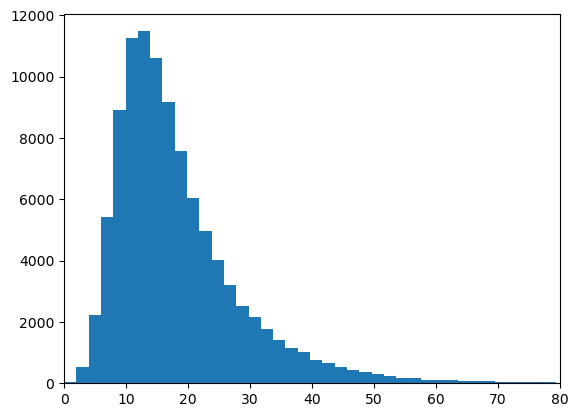

In [270]:
plt.hist(sim_m, bins = 101);
plt.xlim(0, 80)

(0.0, 80.0)

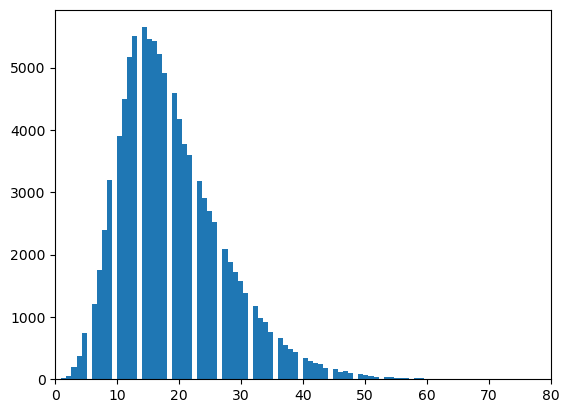

In [269]:
plt.hist(sim_mults, bins = 101);
plt.xlim(0, 80)

(0.0, 0.6)

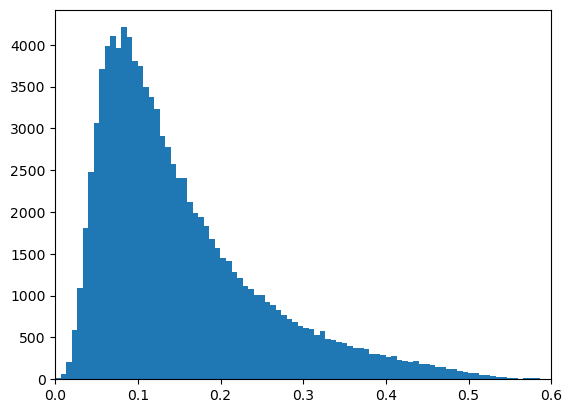

In [272]:
plt.hist(sim_w, bins = 101);
plt.xlim(0, 0.6)

In [324]:
max(sim_jm)

-2.4961507083028924

In [332]:
np.mean(sim_jm > -20)

0.99691

(-20.0, 0.0)

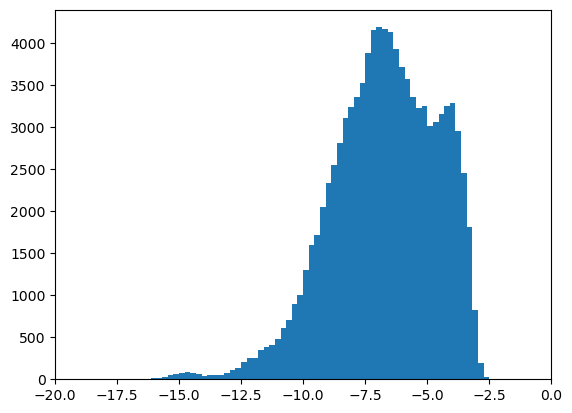

In [331]:
plt.hist(sim_jm, bins = 1001);
plt.xlim(-20, 0)
# Cut events where jet mass outside the range.

(0.0, 1.2)

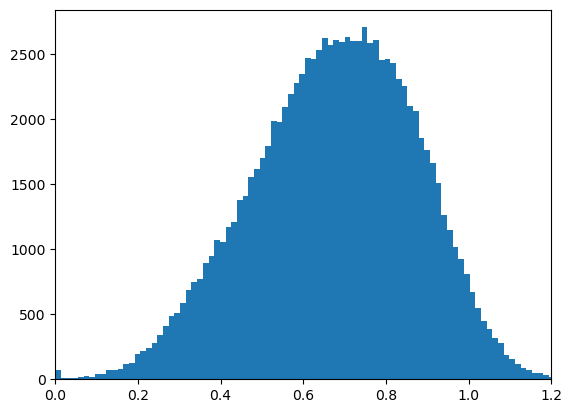

In [310]:
plt.hist(sim_tau21, bins = 101);
plt.xlim(0, 1.2)

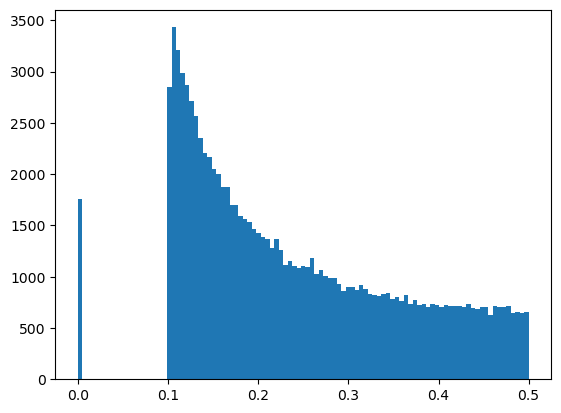

In [299]:
plt.hist(mc['sim_zgs'], bins = 101);

In [ ]:
data = torch.tensor(sim, dtype = torch.float32)
dataset = DataLoader(data, batch_size = 2**6, shuffle = True)

In [ ]:
r = np.load('../batch_losses.npy')

In [ ]:
t = np.load('../total_losses.npy')

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': flow.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'ckpt')

In [ ]:
cp = torch.load('ckpt')

In [ ]:
num_layers = 5
base_dist = StandardNormal(shape=[6])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=6))
    transforms.append(MaskedAffineAutoregressiveTransform(features=6, 
                                                          hidden_features=8))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)

In [ ]:
flow.load_state_dict(cp['model_state_dict'])

# Training

In [ ]:
num_layers = 5
base_dist = StandardNormal(shape=[6])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=6))
    transforms.append(MaskedAffineAutoregressiveTransform(features=6, 
                                                          hidden_features=8))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [ ]:
num_epochs = 100
losses = np.zeros(num_epochs * len(data))

i = 0
for epoch in tqdm.trange(num_epochs):
    for (batch_idx, batch) in enumerate(dataset):
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs = batch).mean()
        loss.backward()
        optimizer.step()
        
        losses[i] = loss
        if i % 100 == 0:
            print(i, '\t', round(losses[i], 2))
        i += 1

In [ ]:
num_iter = 5000
losses = np.zeros(num_iter)
for i in range(num_iter):
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=data).mean()
    losses[i] = loss
    
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        print(i, '\t', round(losses[i], 2))

In [ ]:
plt.plot(range(1, 156300), losses[:156299])
plt.ylim(0, 100)

# Checking

In [ ]:
def ratio_hist(truth, fit,
               labels,
               color = "gray",
               figsize = (8, 8),
               x_lim = None,
               y_lim = None,
               title = None,
               filename = None):
    fig, axs = plt.subplots(2, 1,
                            figsize = figsize,
                            sharex = True, 
                            gridspec_kw = {'height_ratios': [2, 1]})
    
    truth = truth[(truth > x_lim[0]) & (truth < x_lim[1])]
    fit = fit[(fit > x_lim[0]) & (fit < x_lim[1])]
    
    bins = np.linspace(x_lim[0], x_lim[1], 51)
    
    t_hist = axs[0].hist(truth, bins = bins, density = True, color = color, alpha = 0.25, label = labels[0])
    f_hist = axs[0].hist(fit, bins = bins, density = True, histtype = 'step', color = 'red', label = labels[1])
    
    axs[0].minorticks_on()
    axs[0].tick_params(direction='in', which='both')
    axs[0].legend()
    
    if y_lim:
        axs[0].set_ylim(y_lim[0], y_lim[1])
    if x_lim:
        axs[0].set_xlim(x_lim[0], x_lim[1])
    
    bins = (f_hist[1] + np.diff(f_hist[1]).mean() / 2)[:-1]
    axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)
    axs[1].axhline(1,color="gray", lw=0.5)
    
    axs[1].minorticks_on()
    axs[1].tick_params(direction='in', which='both')
    axs[1].set_ylim(0, 2)
    
    plt.xlabel(labels[2])
    
    if title:
        axs[0].set_title(title, loc = "right")
    if filename:
        plt.savefig(filename, 
                    dpi = 300,
                    transparent = True,
                    bbox_inches = 'tight')

## MC

In [7]:
n, d = sim.shape
#sim_smp = flow.sample(n).detach().numpy()

In [ ]:
experiment = 'meep'

### Histograms

In [ ]:
ratio_hist(sim[:, 0], sim_smp[:, 0], 
           labels = ['MC', 'Flow', r'$p_T$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $p_T$ (MC)',
           x_lim = (0, 750),
           filename = '../../plots/zenodo/flows/{}/pT_mc.png'.format(experiment)
          )

In [ ]:
ratio_hist(sim[:, 1], sim_smp[:, 1], 
           labels = ['MC', 'Flow', r'$\eta$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $\eta$ (MC)',
           x_lim = (-5, 5),
           filename = '../../plots/zenodo/flows/{}/eta_mc.png'.format(experiment)
          )

In [ ]:
ratio_hist(sim[:, 2], sim_smp[:, 2], 
           labels = ['MC', 'Flow', r'$\phi$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $\phi$ (MC)',
           x_lim = (-1, 7),
           filename = '../../plots/zenodo/flows/{}/phi_mc.png'.format(experiment)
          )

In [ ]:
ratio_hist(sim[:, 3], sim_smp[:, 3], 
           labels = ['MC', 'Flow', r'$m$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $m$ (MC)',
           x_lim = (0, 80),
           filename = '../../plots/zenodo/flows/{}/m_mc.png'.format(experiment)
          )

In [ ]:
ratio_hist(sim[:, 4], sim_smp[:, 4], 
           labels = ['MC', 'Flow', r'$w$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $w$ (MC)',
           x_lim = (0, 0.6),
           filename = '../../plots/zenodo/flows/{}/w_mc.png'.format(experiment)
          )

In [ ]:
ratio_hist(sim[:, 5], sim_smp[:, 5], 
           labels = ['MC', 'Flow', r'sdms'],
           color = 'green',
           figsize = (w, h),
           title = r'\it sdms (MC)',
           x_lim = (0, 100),
           filename = '../../plots/zenodo/flows/{}/sdms_mc.png'.format(experiment)
          )

### Classification

In [ ]:
X_bkgd = sim_smp
X_sgnl = sim

In [ ]:
np.random.seed(666)

# Create full dataset; randomly sample points from Data or Flow with chance 1/2.
y = stats.bernoulli.rvs(0.5, size = n).astype('float32')
X = np.zeros_like(X_bkgd)

X[y == 0] = X_bkgd[y == 0]
X[y == 1] = X_sgnl[y == 1]

# Take 70% of data to be training data.
N_trn = int(0.7*n)
trn_idx = np.random.choice(range(n), N_trn, replace = False)
tst_idx = [n for n in range(n) if n not in trn_idx]

X_trn = X[trn_idx]
y_trn = y[trn_idx]

X_tst = X[tst_idx]
y_tst = y[tst_idx]

#data, m, s = split_data(X_trn, y_trn)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ab_clf = AdaBoostClassifier()
ab_clf.fit(X_trn, y_trn)

In [ ]:
y_hat = ab_clf.predict_proba(X_tst)[:, 1]
fpr, tpr, ts = metrics.roc_curve(y_tst, y_hat)
auc = metrics.roc_auc_score(y_tst, y_hat)

In [ ]:
fig, ax = plt.subplots(figsize = (w, h))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, ls = ':', c = 'k', lw = 1)

plt.title('\it ROC Curve for MC', loc = 'right')
plt.text(0.05, 0.9, 'AUC: {}'.format(round(auc, 4)))
plt.text(0.04, 0.85, 'Loss: {}'.format(round(losses[156299], 2)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.gca().minorticks_on()
plt.gca().tick_params(direction='in', which='both')
plt.gca().set_aspect('equal')

plt.savefig('../../plots/zenodo/flows/{}/mc_roc.png'.format(experiment), dpi = 300, transparent = True,
            bbox_inches = 'tight')

# Other

In [ ]:
num_layers = 5
base_dist = StandardNormal(shape=[6])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=6))
    transforms.append(MaskedAffineAutoregressiveTransform(features=6, 
                                                          hidden_features=8))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [ ]:
num_iter = 5000
losses = np.zeros(num_iter)
for i in range(num_iter):
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=data).mean()
    losses[i] = loss
    
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        print(i, '\t', round(losses[i], 2))

# Visualizing

## Total

In [10]:
loss_0 = np.load('total_0/losses.npy')
min(loss_0[loss_0 > 0])

12.397750854492188

In [11]:
loss_1 = np.load('total_1/losses.npy')
min(loss_1[loss_1 > 0])

12.532134056091309

(12.3, 13.4)

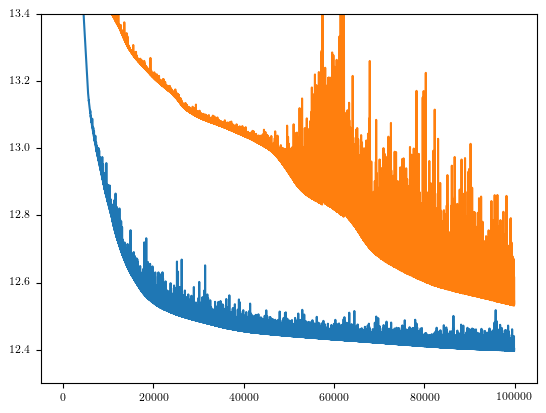

In [12]:
plt.plot(loss_0[loss_0 > 0])
plt.plot(loss_1[loss_1 > 0])
plt.ylim(12.3, 13.4)

## Batches

In [65]:
loss_0 = np.load('batches_0/losses.npy')
min(loss_0[loss_0 > 0]), np.argmin(loss_0[loss_0 > 0])

(11.514670372009277, 739028)

In [67]:
loss_1 = np.load('batches_1/losses.npy')
min(loss_1[loss_1 > 0]), np.argmin(loss_1[loss_1 > 0])

(11.440874099731445, 531419)

In [ ]:
plt.plot(loss_0[loss_0 > 0])
plt.plot(loss_1[loss_1 > 0])
plt.ylim(11.2, 100)

# AUC

In [4]:
#import tensorflow as tf
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

from scipy import stats
import numpy as np
import sklearn.metrics as metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=10)        #22
rc('xtick', labelsize=8)  #15
rc('ytick', labelsize=8)  #15
rc('legend', fontsize=8)  #15
rc('text.latex', preamble=r'\usepackage{amsmath}')

In [5]:
mc = np.load("../../data/zenodo/Pythia21_Zjet_pTZ-200GeV_0.npz")

sim_pt = mc['sim_jets'][:, 0]
sim_eta = mc['sim_jets'][:, 1]
sim_phi = mc['sim_jets'][:, 2]
sim_m = mc['sim_jets'][:, 3]
sim_w = mc['sim_widths']
sim_sdms = mc['sim_sdms']

sim = np.vstack([sim_pt, sim_eta, sim_phi, sim_m, sim_w, sim_sdms]).T

n, d = sim.shape

In [6]:
def calculate_auc(fake, real):
    np.random.seed(666)
    n, d = fake.shape
    y = stats.bernoulli.rvs(0.5, size = n).astype('float32')
    X = np.zeros_like(fake)
    X[y == 0] = real[y == 0]
    X[y == 1] = fake[y == 1]

    # Take 70% of data to be training data.
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, train_size = 0.7)
    ab_clf = AdaBoostClassifier()
    ab_clf.fit(X_trn, y_trn)
    
    y_hat = ab_clf.predict_proba(X_tst)[:, 1]
    auc = metrics.roc_auc_score(y_tst, y_hat)
    return auc

In [7]:
ns = np.arange(0, 99900, 100)
aucs = np.zeros_like(ns)

In [8]:
k = ns[80]

In [9]:
num_layers = 5
base_dist = StandardNormal(shape=[6])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=6))
    transforms.append(MaskedAffineAutoregressiveTransform(features=6, 
                                                          hidden_features=8))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)

In [ ]:
ckpt = torch.load('../nflows/batches_0/ckpt_{}'.format(ns[-1]))
flow.load_state_dict(ckpt['model_state_dict'])

In [ ]:
sim_smp = flow.sample(n).detach().numpy()

In [ ]:
calculate_auc(sim_smp, sim)

In [ ]:
ns = np.arange(0, 99900, 100)
aucs = np.zeros_like(ns)

for i in range(len(ns)):
    k = ns[i]
    
    num_layers = 5
    base_dist = StandardNormal(shape=[6])

    transforms = []
    for _ in range(num_layers):
        transforms.append(ReversePermutation(features=6))
        transforms.append(MaskedAffineAutoregressiveTransform(features=6, 
                                                              hidden_features=8))
    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist)
    ckpt = torch.load('../nflows/total_0/ckpt_{}'.format(k))
    flow.load_state_dict(ckpt['model_state_dict'])
    
    sim_smp = flow.sample(n).detach().numpy()
    aucs[i] = calculate_auc(sim_smp, sim)
    
    print(k, '\t', round(aucs[i], 4))
    #np.save('sim_total_aucs.npy', aucs)

# Histograms

In [136]:
num_layers = 5
base_dist = StandardNormal(shape=[6])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=6))
    transforms.append(MaskedAffineAutoregressiveTransform(features=6, 
                                                          hidden_features=8))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)

In [137]:
def ratio_hist(truth, fit,
               labels,
               color = "gray",
               figsize = (8, 8),
               x_lim = None,
               y_lim = None,
               title = None,
               filename = None):
    fig, axs = plt.subplots(2, 1,
                            figsize = figsize,
                            sharex = True, 
                            gridspec_kw = {'height_ratios': [2, 1]})
    
    truth = truth[(truth > x_lim[0]) & (truth < x_lim[1])]
    fit = fit[(fit > x_lim[0]) & (fit < x_lim[1])]
    
    bins = np.linspace(x_lim[0], x_lim[1], 51)
    
    t_hist = axs[0].hist(truth, bins = bins, density = True, color = color, alpha = 0.25, label = labels[0])
    f_hist = axs[0].hist(fit, bins = bins, density = True, histtype = 'step', color = 'red', label = labels[1])
    
    axs[0].minorticks_on()
    axs[0].tick_params(direction='in', which='both')
    axs[0].legend()
    
    if y_lim:
        axs[0].set_ylim(y_lim[0], y_lim[1])
    if x_lim:
        axs[0].set_xlim(x_lim[0], x_lim[1])
    
    bins = (f_hist[1] + np.diff(f_hist[1]).mean() / 2)[:-1]
    axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)
    axs[1].axhline(1,color="gray", lw=0.5)
    
    axs[1].minorticks_on()
    axs[1].tick_params(direction='in', which='both')
    axs[1].set_ylim(0, 2)
    
    plt.xlabel(labels[2])
    
    if title:
        axs[0].set_title(title, loc = "right")
    if filename:
        plt.savefig(filename, 
                    dpi = 300,
                    transparent = True,
                    bbox_inches = 'tight')

## Total

In [140]:
experiment = 'total_0/99800'

In [141]:
ckpt = torch.load('../nflows/total_0/ckpt_{}'.format(99800))
flow.load_state_dict(ckpt['model_state_dict'])

sim_smp = flow.sample(n).detach().numpy()

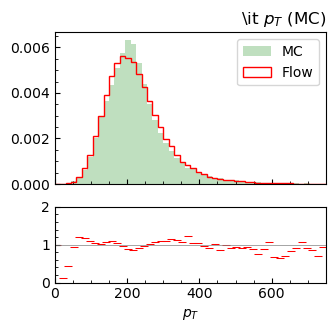

In [142]:
ratio_hist(sim[:, 0], sim_smp[:, 0], 
           labels = ['MC', 'Flow', r'$p_T$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $p_T$ (MC)',
           x_lim = (0, 750),
           filename = '../../plots/zenodo/flows/{}/pT_mc.png'.format(experiment)
          )

/tmp/ipykernel_18813/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


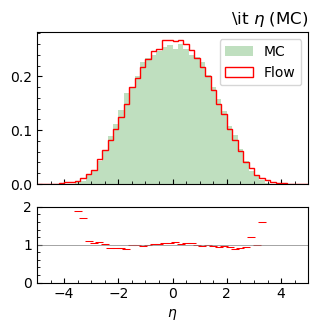

In [143]:
ratio_hist(sim[:, 1], sim_smp[:, 1], 
           labels = ['MC', 'Flow', r'$\eta$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $\eta$ (MC)',
           x_lim = (-5, 5),
           filename = '../../plots/zenodo/flows/{}/eta_mc.png'.format(experiment)
          )

/tmp/ipykernel_18813/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


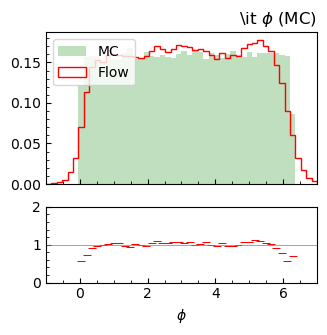

In [144]:
ratio_hist(sim[:, 2], sim_smp[:, 2], 
           labels = ['MC', 'Flow', r'$\phi$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $\phi$ (MC)',
           x_lim = (-1, 7),
           filename = '../../plots/zenodo/flows/{}/phi_mc.png'.format(experiment)
          )

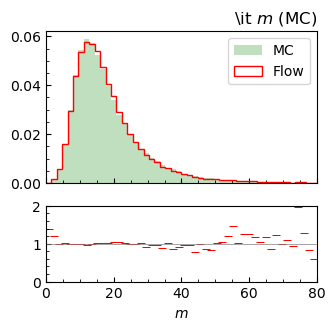

In [145]:
ratio_hist(sim[:, 3], sim_smp[:, 3], 
           labels = ['MC', 'Flow', r'$m$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $m$ (MC)',
           x_lim = (0, 80),
           filename = '../../plots/zenodo/flows/{}/m_mc.png'.format(experiment)
          )

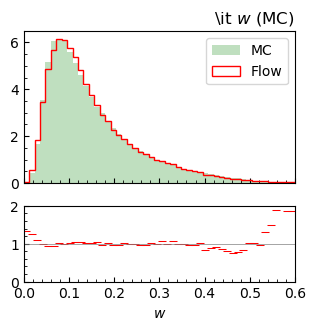

In [146]:
ratio_hist(sim[:, 4], sim_smp[:, 4], 
           labels = ['MC', 'Flow', r'$w$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $w$ (MC)',
           x_lim = (0, 0.6),
           filename = '../../plots/zenodo/flows/{}/w_mc.png'.format(experiment)
          )

/tmp/ipykernel_18813/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


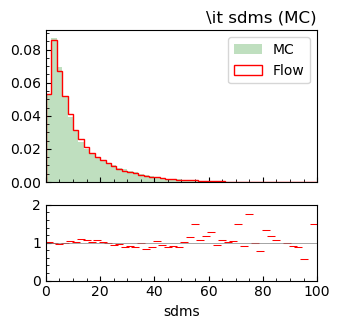

In [147]:
ratio_hist(sim[:, 5], sim_smp[:, 5], 
           labels = ['MC', 'Flow', r'sdms'],
           color = 'green',
           figsize = (w, h),
           title = r'\it sdms (MC)',
           x_lim = (0, 100),
           filename = '../../plots/zenodo/flows/{}/sdms_mc.png'.format(experiment)
          )

In [148]:
experiment = 'total_1/99200'

In [149]:
ckpt = torch.load('../nflows/total_1/ckpt_{}'.format(99200))
flow.load_state_dict(ckpt['model_state_dict'])

sim_smp = flow.sample(n).detach().numpy()

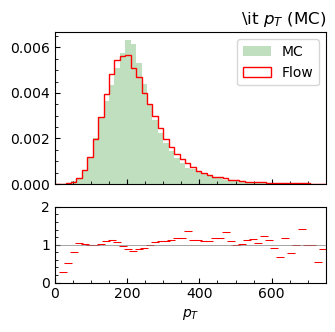

In [150]:
ratio_hist(sim[:, 0], sim_smp[:, 0], 
           labels = ['MC', 'Flow', r'$p_T$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $p_T$ (MC)',
           x_lim = (0, 750),
           filename = '../../plots/zenodo/flows/{}/pT_mc.png'.format(experiment)
          )

/tmp/ipykernel_18813/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


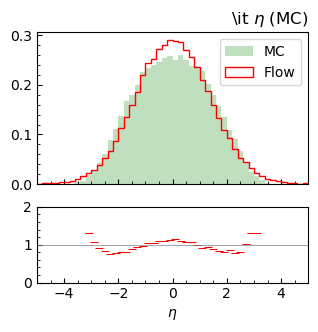

In [151]:
ratio_hist(sim[:, 1], sim_smp[:, 1], 
           labels = ['MC', 'Flow', r'$\eta$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $\eta$ (MC)',
           x_lim = (-5, 5),
           filename = '../../plots/zenodo/flows/{}/eta_mc.png'.format(experiment)
          )

/tmp/ipykernel_18813/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


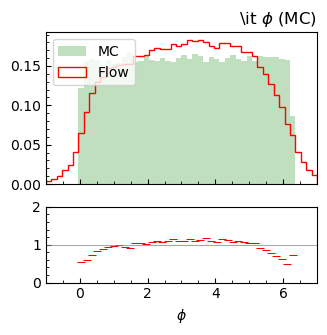

In [152]:
ratio_hist(sim[:, 2], sim_smp[:, 2], 
           labels = ['MC', 'Flow', r'$\phi$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $\phi$ (MC)',
           x_lim = (-1, 7),
           filename = '../../plots/zenodo/flows/{}/phi_mc.png'.format(experiment)
          )

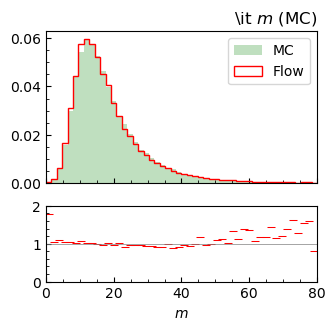

In [153]:
ratio_hist(sim[:, 3], sim_smp[:, 3], 
           labels = ['MC', 'Flow', r'$m$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $m$ (MC)',
           x_lim = (0, 80),
           filename = '../../plots/zenodo/flows/{}/m_mc.png'.format(experiment)
          )

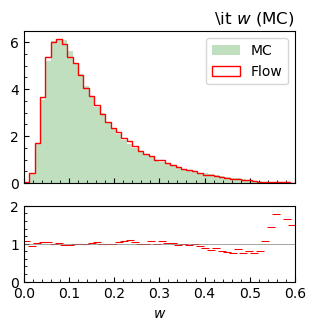

In [154]:
ratio_hist(sim[:, 4], sim_smp[:, 4], 
           labels = ['MC', 'Flow', r'$w$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $w$ (MC)',
           x_lim = (0, 0.6),
           filename = '../../plots/zenodo/flows/{}/w_mc.png'.format(experiment)
          )

/tmp/ipykernel_18813/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


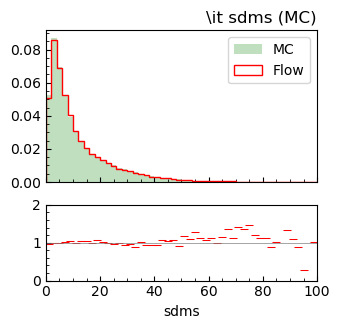

In [155]:
ratio_hist(sim[:, 5], sim_smp[:, 5], 
           labels = ['MC', 'Flow', r'sdms'],
           color = 'green',
           figsize = (w, h),
           title = r'\it sdms (MC)',
           x_lim = (0, 100),
           filename = '../../plots/zenodo/flows/{}/sdms_mc.png'.format(experiment)
          )

## Batches

In [156]:
experiment = 'batches_0/746200'

In [157]:
ckpt = torch.load('../nflows/batches_0/ckpt_{}'.format(746200))
flow.load_state_dict(ckpt['model_state_dict'])

sim_smp = flow.sample(n).detach().numpy()

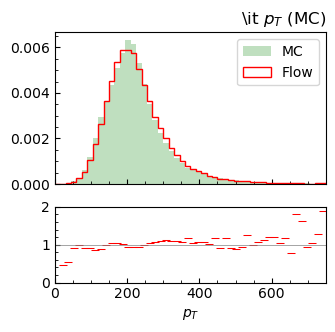

In [158]:
ratio_hist(sim[:, 0], sim_smp[:, 0], 
           labels = ['MC', 'Flow', r'$p_T$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $p_T$ (MC)',
           x_lim = (0, 750),
           filename = '../../plots/zenodo/flows/{}/pT_mc.png'.format(experiment)
          )

/tmp/ipykernel_18813/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)
/tmp/ipykernel_18813/384005121.py:32: RuntimeWarning: invalid value encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


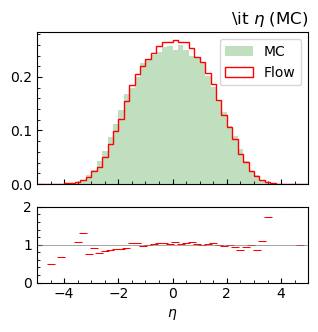

In [159]:
ratio_hist(sim[:, 1], sim_smp[:, 1], 
           labels = ['MC', 'Flow', r'$\eta$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $\eta$ (MC)',
           x_lim = (-5, 5),
           filename = '../../plots/zenodo/flows/{}/eta_mc.png'.format(experiment)
          )

/tmp/ipykernel_18813/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


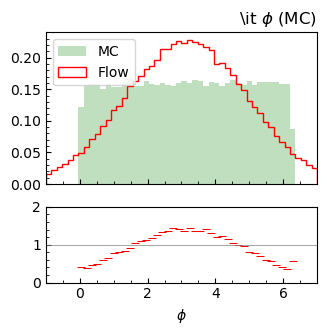

In [160]:
ratio_hist(sim[:, 2], sim_smp[:, 2], 
           labels = ['MC', 'Flow', r'$\phi$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $\phi$ (MC)',
           x_lim = (-1, 7),
           filename = '../../plots/zenodo/flows/{}/phi_mc.png'.format(experiment)
          )

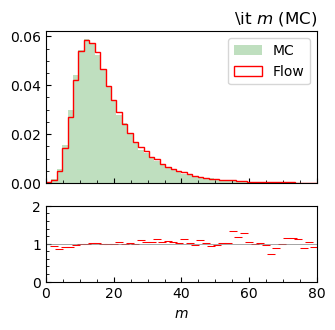

In [161]:
ratio_hist(sim[:, 3], sim_smp[:, 3], 
           labels = ['MC', 'Flow', r'$m$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $m$ (MC)',
           x_lim = (0, 80),
           filename = '../../plots/zenodo/flows/{}/m_mc.png'.format(experiment)
          )

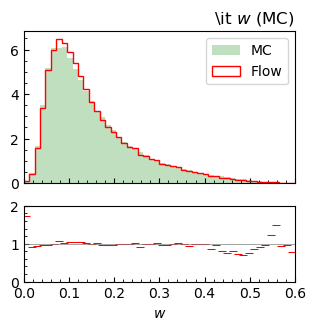

In [162]:
ratio_hist(sim[:, 4], sim_smp[:, 4], 
           labels = ['MC', 'Flow', r'$w$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $w$ (MC)',
           x_lim = (0, 0.6),
           filename = '../../plots/zenodo/flows/{}/w_mc.png'.format(experiment)
          )

/tmp/ipykernel_18813/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


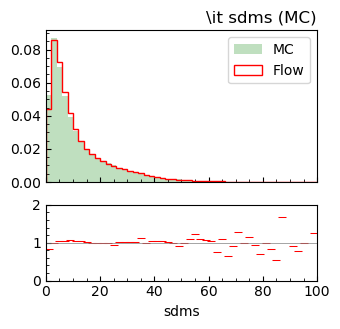

In [163]:
ratio_hist(sim[:, 5], sim_smp[:, 5], 
           labels = ['MC', 'Flow', r'sdms'],
           color = 'green',
           figsize = (w, h),
           title = r'\it sdms (MC)',
           x_lim = (0, 100),
           filename = '../../plots/zenodo/flows/{}/sdms_mc.png'.format(experiment)
          )

In [164]:
experiment = 'batches_1/397100'

In [165]:
ckpt = torch.load('../nflows/batches_1/ckpt_{}'.format(397100))
flow.load_state_dict(ckpt['model_state_dict'])

sim_smp = flow.sample(n).detach().numpy()

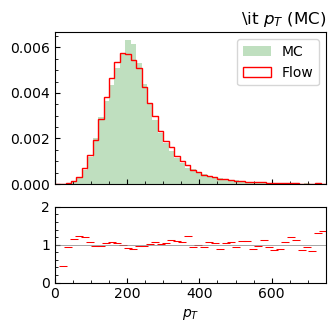

In [166]:
ratio_hist(sim[:, 0], sim_smp[:, 0], 
           labels = ['MC', 'Flow', r'$p_T$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $p_T$ (MC)',
           x_lim = (0, 750),
           filename = '../../plots/zenodo/flows/{}/pT_mc.png'.format(experiment)
          )

/tmp/ipykernel_18813/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)
/tmp/ipykernel_18813/384005121.py:32: RuntimeWarning: invalid value encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


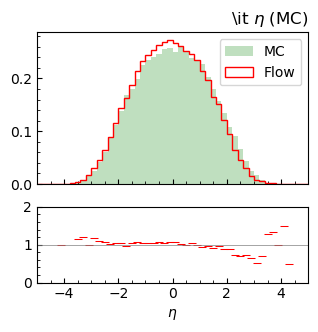

In [167]:
ratio_hist(sim[:, 1], sim_smp[:, 1], 
           labels = ['MC', 'Flow', r'$\eta$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $\eta$ (MC)',
           x_lim = (-5, 5),
           filename = '../../plots/zenodo/flows/{}/eta_mc.png'.format(experiment)
          )

/tmp/ipykernel_18813/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


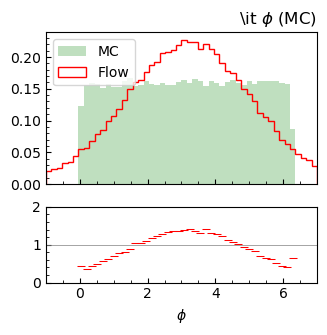

In [168]:
ratio_hist(sim[:, 2], sim_smp[:, 2], 
           labels = ['MC', 'Flow', r'$\phi$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $\phi$ (MC)',
           x_lim = (-1, 7),
           filename = '../../plots/zenodo/flows/{}/phi_mc.png'.format(experiment)
          )

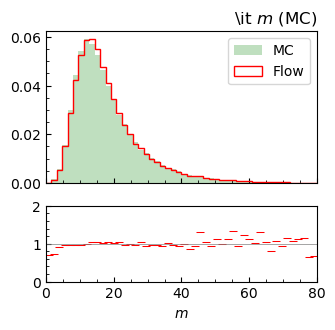

In [169]:
ratio_hist(sim[:, 3], sim_smp[:, 3], 
           labels = ['MC', 'Flow', r'$m$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $m$ (MC)',
           x_lim = (0, 80),
           filename = '../../plots/zenodo/flows/{}/m_mc.png'.format(experiment)
          )

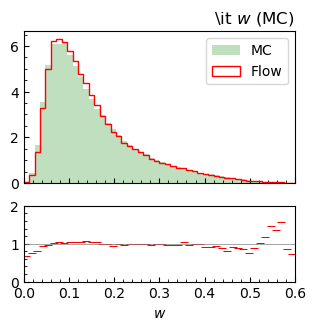

In [170]:
ratio_hist(sim[:, 4], sim_smp[:, 4], 
           labels = ['MC', 'Flow', r'$w$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $w$ (MC)',
           x_lim = (0, 0.6),
           filename = '../../plots/zenodo/flows/{}/w_mc.png'.format(experiment)
          )

/tmp/ipykernel_18813/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


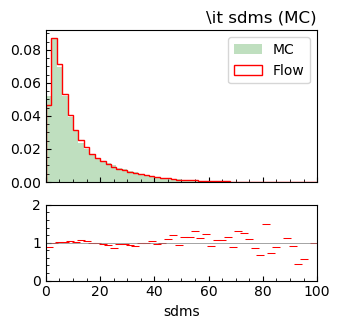

In [171]:
ratio_hist(sim[:, 5], sim_smp[:, 5], 
           labels = ['MC', 'Flow', r'sdms'],
           color = 'green',
           figsize = (w, h),
           title = r'\it sdms (MC)',
           x_lim = (0, 100),
           filename = '../../plots/zenodo/flows/{}/sdms_mc.png'.format(experiment)
          )

In [172]:
def calculate_auc(fake, real):
    np.random.seed(666)
    n, d = fake.shape
    y = stats.bernoulli.rvs(0.5, size = n).astype('float32')
    X = np.zeros_like(fake)
    X[y == 0] = real[y == 0]
    X[y == 1] = fake[y == 1]

    # Take 70% of data to be training data.
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, train_size = 0.7)
    ab_clf = AdaBoostClassifier()
    ab_clf.fit(X_trn, y_trn)
    
    y_hat = ab_clf.predict_proba(X_tst)[:, 1]
    auc = metrics.roc_auc_score(y_tst, y_hat)
    return auc

In [173]:
calculate_auc(sim_smp, sim)

0.6526402266076422

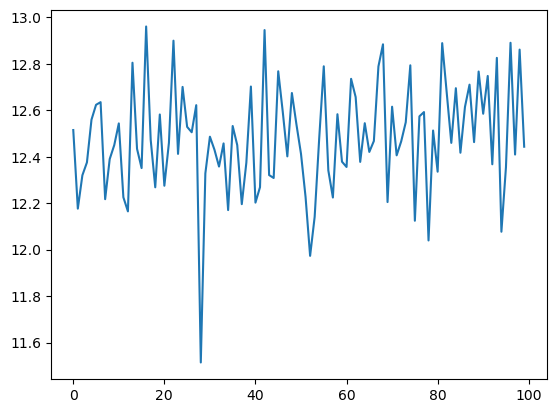

In [99]:
plt.plot(loss_0[739000:739100])

In [114]:
auc_0 = np.load('../sim_batches_0_aucs.npy')

In [115]:
loss_0 = np.load('batches_0/losses.npy')

(10.0, 15.0)

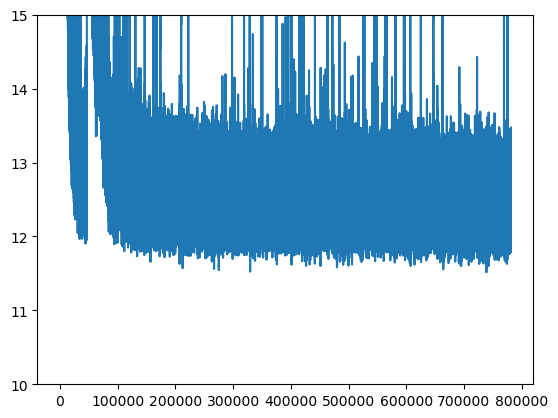

In [116]:
plt.plot(loss_0[loss_0 > 0])
plt.ylim(10, 15)

In [117]:
ns = np.arange(100, 781501, 100)

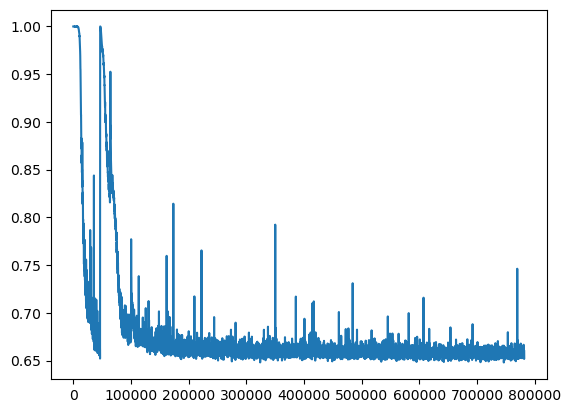

In [118]:
plt.plot(ns, auc_0)

In [119]:
auc_1 = np.load('../sim_batches_1_aucs.npy')

In [120]:
loss_1 = np.load('batches_1/losses.npy')

(10.0, 15.0)

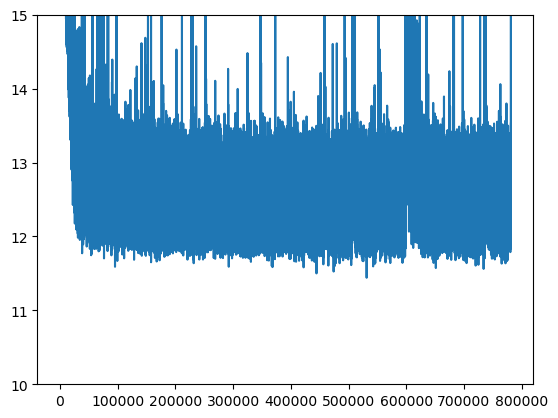

In [121]:
plt.plot(loss_1[loss_1 > 0])
plt.ylim(10, 15)

In [122]:
ns = np.arange(100, 781501, 100)

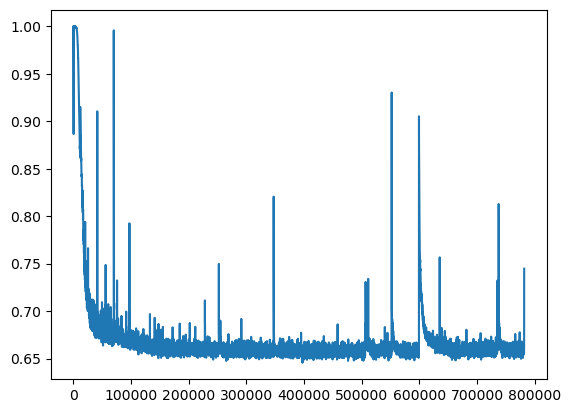

In [123]:
plt.plot(ns, auc_1)

In [125]:
100*(np.argmin(auc_0) + 1), 100*(np.argmin(auc_1) + 1)

(746200, 397100)

In [126]:
auc_0 = np.load('../sim_total_0_aucs.npy')

In [127]:
loss_0 = np.load('total_0/losses.npy')

(10.0, 15.0)

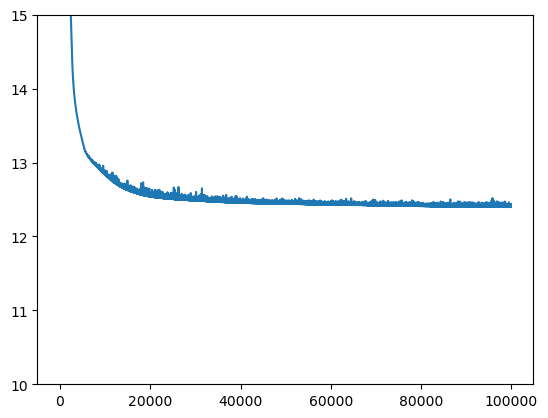

In [128]:
plt.plot(loss_0[loss_0 > 0])
plt.ylim(10, 15)

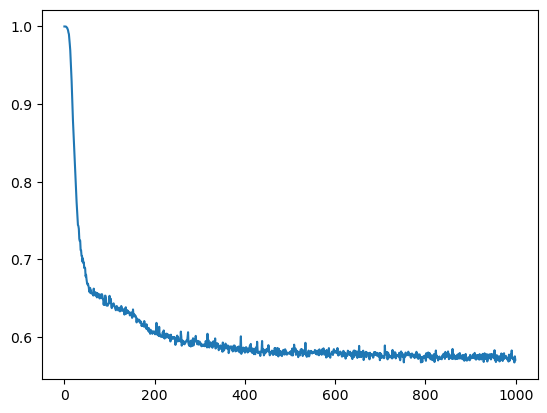

In [129]:
plt.plot(auc_0)

In [130]:
auc_1 = np.load('../sim_total_1_aucs.npy')

In [131]:
loss_1 = np.load('total_1/losses.npy')

(10.0, 15.0)

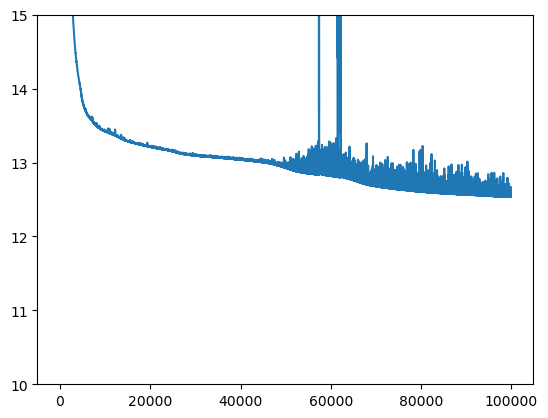

In [132]:
plt.plot(loss_1[loss_1 > 0])
plt.ylim(10, 15)

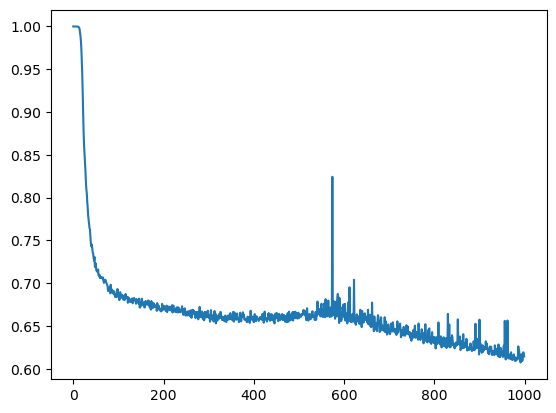

In [134]:
plt.plot(auc_1)

In [135]:
100*(np.argmin(auc_0) + 1), 100*(np.argmin(auc_1) + 1)

(99800, 99200)

In [262]:
loss_2 = np.load('total_2/losses.npy')

13.322637557983398